# Analysis of Continuation HPO results

In [1]:
!pip install baycomp --quiet
!pip install pystan --quiet

In [2]:
from hyperopt import fmin, rand, tpe, hp,Trials
import subprocess
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os.path
import math
import multiprocessing
from functools import partial

plt.style.use('seaborn-whitegrid')

In [3]:
def dataset_info():
    info = json.load(open("data/prep/list.json"))
    return info

In [10]:
problems = [str(x['name']) for x in dataset_info()]
methods = ['TPE', 'HB', 'BOHB', 'CTPE']
trials = range(10)
buckets = [2, 3, 4, 5]

In [11]:
R_DIR = './results/'
df_tpe_loss = pd.read_csv(R_DIR + 'nn-bench/tpe.loss.csv', index_col=[0], header=[0]).apply(pd.to_numeric)
df_ctpe_loss = pd.read_csv(R_DIR  + 'nn-bench/ctpe.loss.csv', index_col=[0,], header=[0, 1]).apply(pd.to_numeric)
df_hb_loss = pd.read_csv(R_DIR + 'nn-bench/hb.loss.csv', index_col=[0], header=[0, 1]).apply(pd.to_numeric)
df_bohb_loss = pd.read_csv(R_DIR + 'nn-bench/bohb.loss.csv', index_col=[0], header=[0, 1]).apply(pd.to_numeric)

## Accuracy

In [12]:
df_loss = pd.DataFrame(columns=methods)

for problem in problems:
    df_problem = pd.DataFrame()
    df_problem['TPE'] = df_tpe_loss.loc[(problem)].to_numpy()

    best_h = df_ctpe_loss.mean().groupby(level='problem').idxmin()[problem]
    df_problem['CTPE'] = df_ctpe_loss.T.loc[best_h].to_numpy()

    best_h = df_hb_loss.mean().groupby(level='problem').idxmin()[problem]
    df_problem['HB'] = df_hb_loss.T.loc[best_h].to_numpy()

    best_h = df_bohb_loss.mean().groupby(level='problem').idxmin()[problem]
    df_problem['BOHB'] = df_bohb_loss.T.loc[best_h].to_numpy()

    df_loss = df_loss.append(df_problem.mean(), ignore_index=True)
df_loss.index = problems

In [13]:
df_loss.style.highlight_min(color = 'lightgreen', axis = 1).highlight_max(color = 'orange', axis = 1)

,TPE,HB,BOHB,CTPE
Facebook metrics,0.002497,0.001156,0.000862,0.001695
Forest fires,0.052814,0.046557,0.046485,0.042692
Aquatic toxicity,0.024839,0.018770,0.018831,0.016255
Fish toxicity,0.012176,0.011550,0.011026,0.010087
Airfoil noise,0.015068,0.015322,0.013324,0.011918
Concrete strenght,0.015021,0.017352,0.014673,0.015099


In [34]:
df_loss.to_latex('results/tables/accuracy.tex', float_format="%.2E", bold_rows=True, longtable=True, 
                caption='Accuracy of several hyper-parameter optimization algorithms while optimizing neural networks hyper-parameters in a benchmarck set of forecasting regression problems.',
                label='nn-accuracy', )

## HPO comparison

In [14]:
ctpe = df_ctpe_loss.mean()

In [15]:
hb = df_hb_loss.mean()

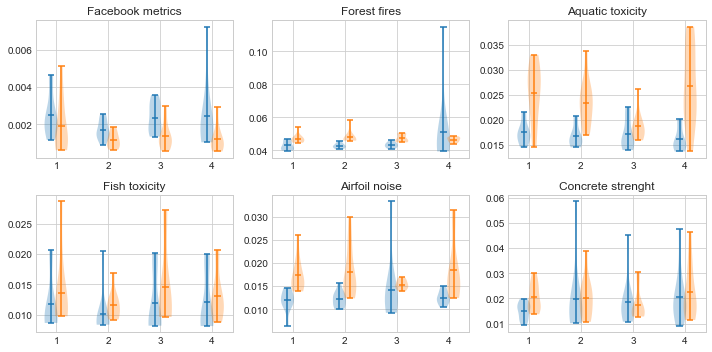

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

for problem, ax in zip(problems, itertools.chain.from_iterable(axs)):
    x = np.arange(1, 5)
    ax.set_title(problem)
    
    ax.violinplot(dataset=df_ctpe_loss[problem].values, showmeans=True, positions=x - 0.1, widths=0.25)
    ax.violinplot(dataset=df_hb_loss[problem].values, showmeans=True, positions=x + 0.1, widths=0.25)

fig.tight_layout()

In [52]:
fig.savefig('results/img/hpo_conf.pdf',bbox_inches='tight')

## Statistical comparison

In [19]:
import mybaycomp as bc   # Just baycomp package with small modifications in the plot properties

In [22]:
def data(method):
    df_loss = pd.DataFrame()

    for problem in problems:
        df_problem = pd.DataFrame()
        df_problem['TPE'] = df_tpe_loss.loc[(problem)].to_numpy()

        best_h = df_ctpe_loss.mean().groupby(level='problem').idxmin()[problem]
        df_problem['CTPE'] = df_ctpe_loss.T.loc[best_h].to_numpy()

        best_h = df_hb_loss.mean().groupby(level='problem').idxmin()[problem]
        df_problem['HB'] = df_hb_loss.T.loc[best_h].to_numpy()

        best_h = df_bohb_loss.mean().groupby(level='problem').idxmin()[problem]
        df_problem['BOHB'] = df_bohb_loss.T.loc[best_h].to_numpy()

        df_loss = df_loss.append(df_problem[method])

    return df_loss

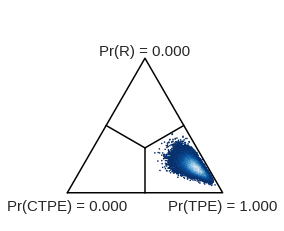

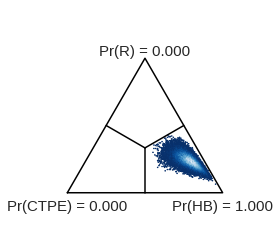

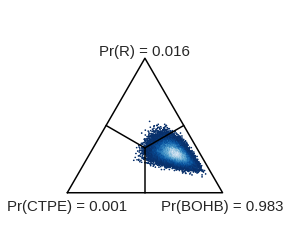

In [28]:
methods = ['TPE', 'HB', 'BOHB']
method1 = data('CTPE').values.ravel()
for j in range(len(methods)):
    method2 = data(methods[j]).values.ravel()
    probs, fig = bc.two_on_multiple(method1, method2, runs=10, rope=0.001, plot=True, names=('CTPE', methods[j]))
    fig.savefig("results/img/CTPEvs" + methods[j] + ".pdf",bbox_inches='tight')